# libraries

In [61]:
!pip install qnm

In [62]:
# libraries
import os
import re
import time
import copy
import qnm # https://arxiv.org/abs/1908.10377
import torch
import numpy as np
import pandas as pd
from tqdm import tqdm
dtype=torch.float32
torch.set_default_dtype(dtype)
import torch.optim as optim
from torch.autograd import grad
from torch.autograd import Variable
from itertools import product
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader, IterableDataset

from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# plots

In [70]:
a = [0.1, 0.2, 0.3, 0.4]
ell = [2.0]
m = [2.0]
n = [0.0, 1.0, 2.0, 3.0, 4.0, 5.0]


mode = [dict(zip(["ell", "m", "n"], [i, j, k])) for i, j, k in product(ell, m, n)]

del ell
del m
del n

f1_res_dict, f2_res_dict, g1_res_dict, g2_res_dict = dict(), dict(), dict(), dict()
a_dict = dict()

for a_ in a:
   f1_res_dict, f2_res_dict, g1_res_dict, g2_res_dict = dict(), dict(), dict(), dict()
   for i in range(len(mode)):
      ell = mode[i]["ell"]
      m = mode[i]["m"]
      n = mode[i]["n"]

      f_res = 'RODE_a%sell%sm%sn%s.csv'%(a_, ell, m, n)
      f_res = pd.read_csv('gdrive/MyDrive/qnm_data_updated/'+ f_res, names=["x", "f1_res", "f2_res"])

      mask1 = f_res["f1_res"] == 'Indeterminate'
      mask2 = f_res["f2_res"] == 'Indeterminate'

      f_res.loc[mask1, "f1_res"] = 0
      f_res.loc[mask2, "f2_res"] = 0

      f_res = f_res.astype('float32').to_numpy()

      g_res = 'GODE_a%sell%sm%sn%s.csv'%(a_, ell, m, n)
      g_res = pd.read_csv('gdrive/MyDrive/qnm_data_updated/'+ g_res, names=["u", "g1_res", "g2_res"])

      mask1 = g_res["g1_res"] == 'Indeterminate'
      mask2 = g_res["g2_res"] == 'Indeterminate'

      g_res.loc[mask1, "g1_res"] = 0
      g_res.loc[mask2, "g2_res"] = 0

      g_res = g_res.astype('float32').to_numpy()

      f1_res_dict.update({"ell_%s_m_%s_n_%s" %(ell, m, n): np.abs(f_res[:, 1:2]).mean()})
      f2_res_dict.update({"ell_%s_m_%s_n_%s" %(ell, m, n): np.abs(f_res[:, 2:3]).mean()})
      g1_res_dict.update({"ell_%s_m_%s_n_%s" %(ell, m, n): np.abs(g_res[:, 1:2]).mean()})
      g2_res_dict.update({"ell_%s_m_%s_n_%s" %(ell, m, n): np.abs(g_res[:, 2:3]).mean()})

   a_dict.update({"a_%s" %(a_): (f1_res_dict, f2_res_dict, g1_res_dict, g2_res_dict)})
   del f1_res_dict
   del f2_res_dict
   del g1_res_dict
   del g2_res_dict

del a
del a_
del m
del ell
del n
def plot_residuals_vs_overtones(a_dict,
                                size=18):

    plt.rc('xtick', labelsize=size)
    plt.rcParams.update({'font.size': size})
    plt.rc('font', size=size)
    plt.rc('axes', titlesize=size)
    plt.rc('axes', labelsize=size)
    plt.rc('legend', fontsize=size)

    a = [0.1, 0.2, 0.3, 0.4]
    n = [0.0, 1.0, 2.0, 3.0, 4.0, 5.0]

    f, ax = plt.subplots(figsize = (8,6))
    for i in a:
        f1_res_dict, f2_res_dict, g1_res_dict, g2_res_dict = a_dict["a_%s" %(i)]
        f1_res_, f2_res_, g1_res_, g2_res_ = [], [], [], []
        for j in n :
            f1_res_.append(f1_res_dict["ell_2.0_m_2.0_n_%s" %(j)])
            f2_res_.append(f2_res_dict["ell_2.0_m_2.0_n_%s" %(j)])
        if i == 0.1:
           ls = "solid"
        elif i == 0.2:
           ls = "dashed"
        elif i == 0.3:
           ls = "dotted"
        elif i == 0.4:
           ls = "dashdot"
        plt.plot(n , f1_res_, "-b", linestyle = ls, alpha=0.975, label="$a = %s$" %(i));
        plt.plot(n , f2_res_, "-r", linestyle = ls, alpha=0.975);
        del f1_res_
        del f2_res_
    f.tight_layout()
    plt.xlabel("$n$")
    plt.ylabel("$\Delta PDE(r)$")
    plt.yscale("log")
    plt.legend(loc='upper left')
    xticks = [0, 1, 2, 3, 4, 5]
    xlabels = ["%s"%(x) for x in xticks]
    plt.xticks(xticks, labels=xlabels)
    plt.title("$\ell = m = 2.0$,\n $n = \{0.1, 0.2, 0.3, 0.4\}$. $n = \{0, 1, 2, 3, 4, 5 \}$")
    plt.savefig('deltaradial.pdf', bbox_inches = 'tight')

    f, ax = plt.subplots(figsize = (8,6))
    for i in a:
        f1_res_dict, f2_res_dict, g1_res_dict, g2_res_dict = a_dict["a_%s" %(i)]
        f1_res_, f2_res_, g1_res_, g2_res_ = [], [], [], []
        for j in n :
            g1_res_.append(g1_res_dict["ell_2.0_m_2.0_n_%s" %(j)])
            g2_res_.append(g2_res_dict["ell_2.0_m_2.0_n_%s" %(j)])
        if i == 0.1:
           ls = "solid"
        elif i == 0.2:
           ls = "dashed"
        elif i == 0.3:
           ls = "dotted"
        elif i == 0.4:
           ls = "dashdot"
        plt.plot(n , g1_res_, "-b", linestyle = ls, alpha=0.975, label="$a = %s$" %(i));
        plt.plot(n , g2_res_, "-r", linestyle = ls, alpha=0.975);
        del f1_res_
        del f2_res_
    f.tight_layout()
    plt.xlabel("$n$")
    plt.ylabel("$\Delta PDE(\\theta)$")
    plt.yscale("log")
    plt.legend(loc='upper left')
    xticks = [0, 1, 2, 3, 4, 5]
    xlabels = ["%s"%(x) for x in xticks]
    plt.xticks(xticks, labels=xlabels)
    plt.title("$\ell = m = 2.0$,\n $n = \{0.1, 0.2, 0.3, 0.4\}$. $n = \{0, 1, 2, 3, 4, 5 \}$")
    plt.savefig('deltaangular.pdf', bbox_inches = 'tight')




<ipython-input-70-8141c962c456>:89: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-b" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(n , f1_res_, "-b", linestyle = ls, alpha=0.975, label="$a = %s$" %(i));
<ipython-input-70-8141c962c456>:90: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-r" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(n , f2_res_, "-r", linestyle = ls, alpha=0.975);
<ipython-input-70-8141c962c456>:119: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-b" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(n , g1_res_, "-b", linestyle = ls, alpha=0.975, label="$a = %s$" %(i));
<ipython-input-70-8141c962c456>:120: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-r" (-> linestyle='

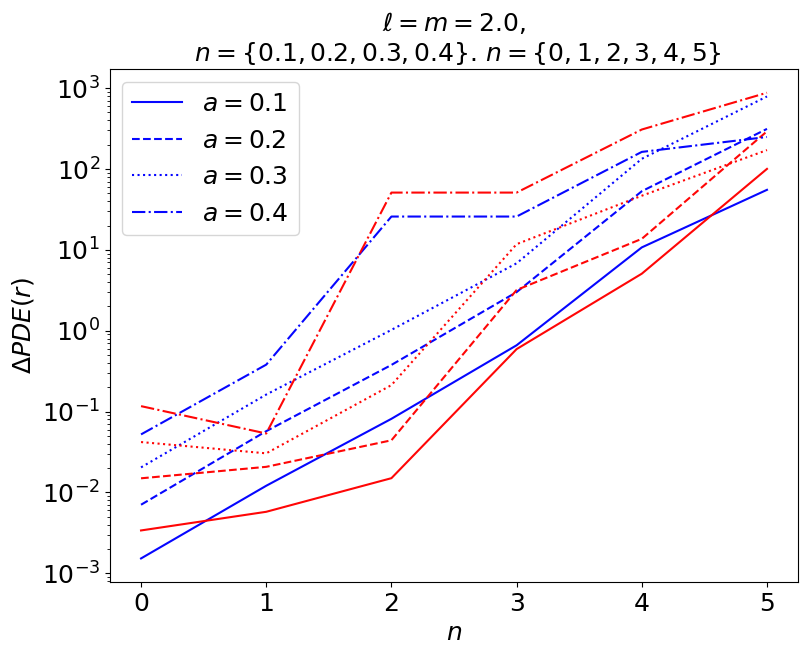

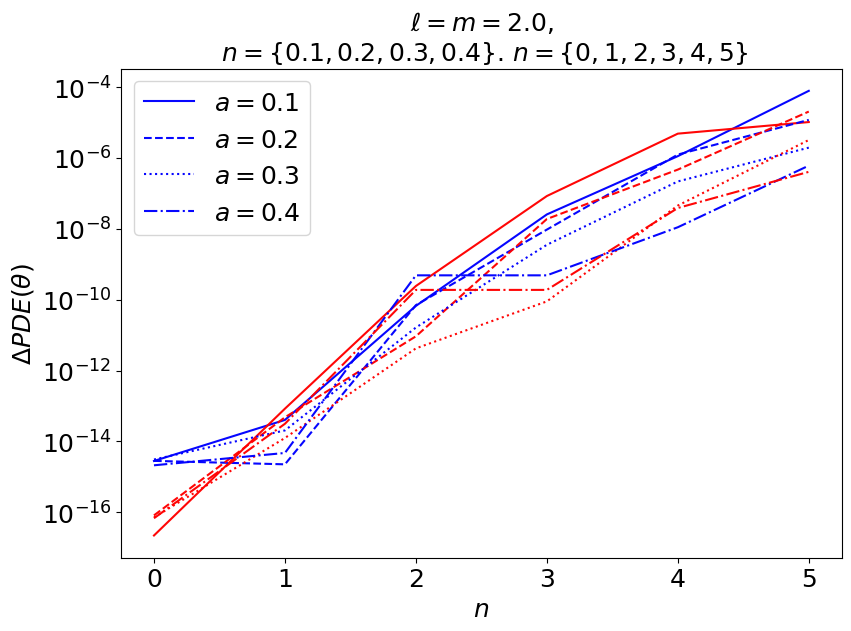

In [71]:
plot_residuals_vs_overtones(a_dict,
                            size=18)

In [65]:
a_dict["a_0.3"]

({'ell_2.0_m_2.0_n_0.0': 0.020428257,
  'ell_2.0_m_2.0_n_1.0': 0.16247024,
  'ell_2.0_m_2.0_n_2.0': 1.0241725,
  'ell_2.0_m_2.0_n_3.0': 6.818191,
  'ell_2.0_m_2.0_n_4.0': 133.64444,
  'ell_2.0_m_2.0_n_5.0': 788.1335},
 {'ell_2.0_m_2.0_n_0.0': 0.042018875,
  'ell_2.0_m_2.0_n_1.0': 0.030469166,
  'ell_2.0_m_2.0_n_2.0': 0.21254174,
  'ell_2.0_m_2.0_n_3.0': 11.761326,
  'ell_2.0_m_2.0_n_4.0': 46.69375,
  'ell_2.0_m_2.0_n_5.0': 171.33347},
 {'ell_2.0_m_2.0_n_0.0': 3.0918115e-15,
  'ell_2.0_m_2.0_n_1.0': 2.0482417e-14,
  'ell_2.0_m_2.0_n_2.0': 1.6442379e-11,
  'ell_2.0_m_2.0_n_3.0': 3.557533e-09,
  'ell_2.0_m_2.0_n_4.0': 2.1866168e-07,
  'ell_2.0_m_2.0_n_5.0': 1.9666115e-06},
 {'ell_2.0_m_2.0_n_0.0': 7.2002625e-17,
  'ell_2.0_m_2.0_n_1.0': 1.25150905e-14,
  'ell_2.0_m_2.0_n_2.0': 4.240525e-12,
  'ell_2.0_m_2.0_n_3.0': 8.9845596e-11,
  'ell_2.0_m_2.0_n_4.0': 4.556602e-08,
  'ell_2.0_m_2.0_n_5.0': 3.2301393e-06})